In [87]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import random
import nltk
from pprint import pprint
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
import numpy as np
from IPython.display import display, HTML
import collections

# Setting width of the notebook to 85% of screen width
display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 80%; }
</style>
"""))

%matplotlib inline
nltk.download('wordnet',quiet=True)
lmtzr = WordNetLemmatizer()

In [88]:
def load(path, kind):
    pickle_path = '{}/master.pkl'.format(path)
    if os.path.exists(pickle_path):
        return pd.read_pickle(pickle_path, compression='gzip')
    
    df = pd.DataFrame(columns=['_document','_data','_class'])
    
    for root, dirname, files in os.walk('{}/{}/neg'.format(path,kind)):
        files = [os.path.join(root,fname) for fname in files]
        for file in files:
            with open(file, 'rt') as f:
                df = df.append({'_document':file,'_data':f.read(), '_class':'neg'}, ignore_index=True)

        for root, dirname, files in os.walk('{}/{}/pos'.format(path,kind)):
            files = [os.path.join(root,fname) for fname in files]
            for file in files:
                with open(file, 'rt') as f:
                    df = df.append({'_document': file,'_data':f.read(), '_class':'pos'}, ignore_index=True)
    df.to_pickle(pickle_path, compression='gzip')
    return df

In [89]:
df = load('data/aclImdb','train')
df = df.sample(frac=1.0)

In [90]:
def split(df, sl):
    sl = int(df.shape[0]*sl)
    return (df[:sl].copy(), df[sl:].copy())

In [91]:
train_df, dev_df = split(df, 0.8)

In [92]:
def remove_punctuation(document):
    document = document.lower()
#     document = re.sub('[-:;\'\"()?!]', ' ', document)
    document = re.sub('</*\s*\w+\s*/*>', '', document)
    document = re.sub('\W+',' ',document)
#     document = re.sub('\.+',' ',document)
#     document = re.sub('\d+','',document)
    document = re.sub('\s+',' ', document)
    return document.split(' ')

In [93]:
stopwords = ["a","i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
             "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", 
             "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
             "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
             "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
             "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for",
             "with", "about", "against", "between", "into", "through", "during", "before", "after", "above",
             "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
             "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", 
             "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only",
             "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

def remove_stopwords(document):
    return list(filter(lambda word: word not in stopwords, document))
    

In [94]:
def remove_rare_words(document):
    unq = set(document)
    return list(filter(lambda word: document.count(word)>5, unq))

In [95]:
def prepare_vocab(df):
    wc = []
    df['_data'].apply(lambda data: wc.extend(data))
    wc = dict(collections.Counter(wc))
    print('Total distinct words before removing rare words: {}'.format(len(wc.keys())))
    wc = [ k for k,v in wc.items() if v>5 ]
    print('Total distinct words after removing rare words: {}'.format(len(wc)))
    return wc

In [96]:
def eliminate_rare_words(document, vocab):
    document = set(document).intersection(vocab)
    document.discard('')
    return document

In [97]:
def lemmatize(document):
    return [lmtzr.lemmatize(word) for word in document]

### Clean train set and build vocabulary

In [98]:
train_df['_data'] = train_df['_data'].apply(remove_punctuation).apply(remove_stopwords).apply(lemmatize)
vocabulary = {}
vocabulary['train'] = prepare_vocab(train_df)
train_df['_data'] = train_df['_data'].apply(lambda doc: eliminate_rare_words(doc,vocabulary['train']))
    
print(train_df.shape)
train_df.head(10)

Total distinct words before removing rare words: 62273
Total distinct words after removing rare words: 21399
(20000, 3)


,_document,_data,_class
10883,data/aclImdb/train/neg/4886_1.txt,"{vcr, pseudonym, return, style, film, tried, v...",neg
20610,data/aclImdb/train/pos/6747_8.txt,"{bar, gene, ll, morality, leaf, role, among, b...",pos
18502,data/aclImdb/train/pos/2165_7.txt,"{though, impulse, creative, movie, along, scri...",pos
12991,data/aclImdb/train/pos/3661_10.txt,"{degree, sleep, end, serious, snob, convoluted...",pos
23431,data/aclImdb/train/pos/12160_10.txt,"{comic, kid, weaver, underrated, tot, untalent...",pos
3479,data/aclImdb/train/neg/9607_4.txt,"{film, else, chick, brutally, right, flashback...",neg
23698,data/aclImdb/train/pos/11662_9.txt,"{money, film, named, attempt, look, watching, ...",pos
14831,data/aclImdb/train/pos/6328_10.txt,"{worth, gratifying, piece, understandably, bri...",pos
12648,data/aclImdb/train/pos/2671_7.txt,"{cake, perform, film, won, jodie, expensive, s...",pos
15517,data/aclImdb/train/pos/1419_7.txt,"{bar, worth, penguin, word, eat, endurance, gr...",pos


In [99]:
dev_df['_data'] = dev_df['_data'].apply(remove_punctuation).apply(remove_stopwords).apply(lemmatize)
vocabulary['dev'] = prepare_vocab(dev_df)
dev_df['_data'] = dev_df['_data'].apply(lambda doc: eliminate_rare_words(doc, vocabulary['dev']))
    
print(dev_df.shape)
dev_df.head(10)

Total distinct words before removing rare words: 34503
Total distinct words after removing rare words: 10027
(5000, 3)


,_document,_data,_class
4691,data/aclImdb/train/neg/8106_1.txt,"{statement, comic, melodramatic, white, ludicr...",neg
21052,data/aclImdb/train/pos/1248_8.txt,"{though, comic, four, movie, lost, good, unusu...",pos
24507,data/aclImdb/train/pos/9773_7.txt,"{worth, horrific, opera, older, look, budget, ...",pos
18440,data/aclImdb/train/pos/10355_9.txt,"{love, circus, melodramatic, barely, movie, ha...",pos
14907,data/aclImdb/train/pos/6596_8.txt,"{la, narration, style, shining, 2004, brutalit...",pos
512,data/aclImdb/train/neg/10669_2.txt,"{face, movie, name, recipe, centered, suspense...",neg
9422,data/aclImdb/train/neg/8152_2.txt,"{ll, comic, many, mel, lousy, battle, high, fi...",neg
6493,data/aclImdb/train/neg/3031_2.txt,"{destroys, brat, extreme, coleman, film, situa...",neg
16809,data/aclImdb/train/pos/6516_10.txt,"{white, end, movie, mood, day, altogether, fav...",pos
11403,data/aclImdb/train/neg/2061_1.txt,"{smart, kid, end, brain, script, day, cheap, l...",neg


### Clean dev set and build vocabulary

In [100]:
pos = train_df[train_df['_class']=='pos']['_data'].apply(lambda x: ' '.join(x)).values
neg = train_df[train_df['_class']=='neg']['_data'].apply(lambda x: ' '.join(x)).values

### Most occurring words

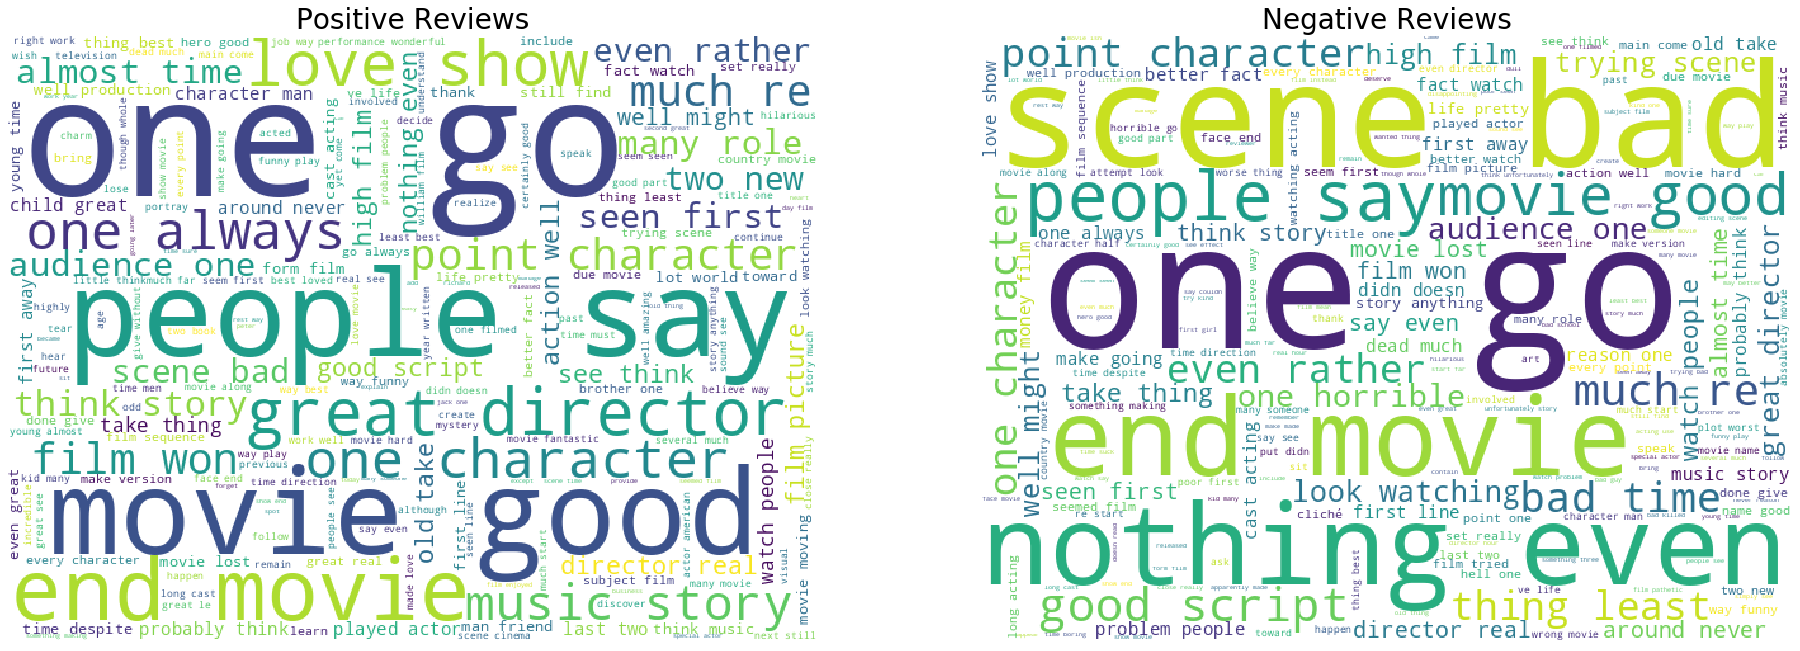

In [101]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[32,18])
cloud1 = WordCloud(background_color='white',width=640,height=480).generate(' '.join(pos))
cloud2 = WordCloud(background_color='white', width=640,height=480).generate(' '.join(neg))

ax1.imshow(cloud1)
ax1.axis('off')
ax1.set_title('Positive Reviews', fontsize=28)

ax2.imshow(cloud2)
ax2.axis('off')
ax2.set_title('Negative Reviews', fontsize=28)
plt.show()

# Determine Accuracy over dev set

In [102]:
word_counts = {}
for word in vocabulary['train']:
    docs_with_word = train_df[train_df['_data'].map(set([word]).issubset)]
    pos_docs_with_word = docs_with_word[docs_with_word['_class']=='pos'].shape[0]
    neg_docs_with_word = docs_with_word[docs_with_word['_class']=='neg'].shape[0]
    word_counts[word] = {'pos': pos_docs_with_word, 'neg': neg_docs_with_word}

In [103]:
num_sentiment = {}
num_sentiment['pos'] = train_df[train_df['_class']=='pos'].shape[0]
num_sentiment['neg'] = train_df[train_df['_class']=='neg'].shape[0]

def get_conditional(word, sentiment):
    if word not in word_counts:
        return 0
    return word_counts[word][sentiment]/num_sentiment[sentiment]

In [104]:
def get_posterior(document, sentiment):
    p = num_sentiment[sentiment]/train_df.shape[0]
#     print("# of {} records:{}, # of records{}, P({})={}".format(sentiment, num_sentiment[sentiment],train_df.shape[0], sentiment,p))
    for word in document:
#         print('P({}|{}) = {}'.format(word, sentiment, get_conditional(word, sentiment)))
        p *= get_conditional(word, sentiment)
#         print("P(class={}| {}) = {}\n\n".format(sentiment, ','.join(document),p))
    return p

In [105]:
def determine_class(row):
    r = {'pos':'neg','neg':'pos'}
    if row['_pos'] == 0 and row['_neg'] == 0:
        return r[row['_class']]
    if row['_pos'] >= row['_neg']:
        return 'pos'
    else:
        return 'neg'

In [106]:
dev_df['_pos'] = dev_df['_data'].apply(lambda doc: get_posterior(doc, 'pos'))
dev_df['_neg'] = dev_df['_data'].apply(lambda doc: get_posterior(doc, 'neg'))
dev_df['_predicted_class'] = dev_df.apply(determine_class,axis=1)

In [107]:
dev_df.head()

,_document,_data,_class,_pos,_neg,_predicted_class
4691,data/aclImdb/train/neg/8106_1.txt,"{statement, comic, melodramatic, white, ludicr...",neg,3.726996e-105,7.541767e-102,neg
21052,data/aclImdb/train/pos/1248_8.txt,"{though, comic, four, movie, lost, good, unusu...",pos,1.409363e-63,7.967045e-65,pos
24507,data/aclImdb/train/pos/9773_7.txt,"{worth, horrific, opera, older, look, budget, ...",pos,1.234794e-125,2.882349e-124,neg
18440,data/aclImdb/train/pos/10355_9.txt,"{love, circus, melodramatic, barely, movie, ha...",pos,3.260697e-131,3.798713e-139,pos
14907,data/aclImdb/train/pos/6596_8.txt,"{la, narration, style, shining, 2004, brutalit...",pos,2.074276e-141,1.970811e-143,pos


In [108]:
acc = dev_df[dev_df['_class']==dev_df['_predicted_class']].shape[0]/dev_df.shape[0]

0.7474